# Phase 3: SAE Comparison & Advanced Analysis

## Objectives

1. Load and compare multiple pre-trained SAEs (different layers, different architectures)
2. Run systematic feature analysis on each SAE
3. Compare specialist feature discovery across different SAEs
4. Understand how SAE architecture and training location affect feature interpretability
5. Document which SAE configurations produce the most useful monosemantic features

## What We'll Learn

- How different SAE training locations (residual stream vs MLP output) affect learned features
- Whether deeper layers learn more specialized features than shallow layers
- Which SAE configurations produce the best domain specialists (code, math, languages, etc.)
- How to systematically compare interpretability across multiple decompositions
- Trade-offs between different SAE architectures for understanding model internals

## Research Questions

- **Layer Depth**: Do layers 8 and 10 learn more specialized features than layer 6?
- **Hook Point Type**: Do MLP-output SAEs differ meaningfully from residual-stream SAEs?
- **Specialist Discovery**: Can we find better code specialists, emoji specialists, or language-specific features in other SAEs?
- **General vs Specific**: Which SAE produces the optimal balance of general and specialist features?

## Available SAEs for Comparison

We'll systematically test:
- **Layer 6 Residual Stream** (`6-res-jb`) - our Phase 2 baseline
- **Layer 8 Residual Stream** (`8-res-jb`) - deeper processing
- **Layer 10 Residual Stream** (`10-res-jb`) - near output layers
- **Layer 6 MLP Output** (`6-mlp-out`) - different information stream

## Methodology

For each SAE, we'll:
1. Extract features from our 70-text diverse dataset (Python, URLs, Math, Non-English, Social/Emoji, Formal, Conversational)
2. Run all Phase 2 analyses: strongest, frequent, selective, and category-specialist searches
3. Record specialist scores for each of the 7 categories
4. Compare feature interpretability using Neuronpedia
5. Aggregate results to determine which SAE is most useful for interpretability

## Expected Outcomes

- Comparative analysis showing which SAE types learn the best specialists
- Evidence for or against the hypothesis that deeper layers = more specialized features
- Recommendations for which SAE to use for specific interpretability tasks
- Foundation for understanding how SAE training location affects decomposition quality

## Prerequisites

- Completed Phase 1 (model loaded, initial activations cached)
- Completed Phase 2 (diverse dataset created, analysis pipeline built)
- Cached data: `../data/phase1_activations.pt` (optional, will extract fresh if needed)
- Phase 2 code: Feature discovery methods and visualization tools

In [1]:
# ============================================================================
# CELL 2: Import Libraries
# ============================================================================

import html
from IPython.display import display, Markdown
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML
import os
import warnings
warnings.filterwarnings('ignore')

# TransformerLens and SAELens
from transformer_lens import HookedTransformer
from sae_lens import SAE

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✅ All libraries imported successfully!
PyTorch version: 2.9.0+cpu
Device: cpu


In [2]:
# ============================================================================
# CELL 3: Check SAE Cache Status
# ============================================================================

from pathlib import Path
import os

print("🔍 Checking SAE Cache Status")
print("=" * 70)

# SAEs can be cached in two locations:
# 1. Direct SAELens cache: ~/.cache/sae_lens/
# 2. HuggingFace hub cache: ~/.cache/huggingface/hub/

sae_lens_cache = Path.home() / ".cache" / "sae_lens"
hf_cache = Path.home() / ".cache" / "huggingface" / "hub"

required_saes = {
    "6-res-jb": "blocks.6.hook_resid_pre",
    "8-res-jb": "blocks.8.hook_resid_pre", 
    "10-res-jb": "blocks.10.hook_resid_pre",
    "11-res-jb": "blocks.11.hook_resid_pre"
    
}

def check_sae_cached(sae_path):
    """Check if SAE is cached in either location"""
    # Check direct cache
    direct_path = sae_lens_cache / sae_path
    if direct_path.exists() and (direct_path / "sae_weights.safetensors").exists():
        return True, direct_path
    
    # Check HuggingFace cache
    if hf_cache.exists():
        for root, dirs, files in os.walk(hf_cache):
            if sae_path in root and "sae_weights.safetensors" in files:
                return True, Path(root)
    
    return False, None

all_cached = True
for sae_name, sae_path in required_saes.items():
    is_cached, cache_path = check_sae_cached(sae_path)
    if is_cached:
        print(f"✅ {sae_name}: Cached at {cache_path}")
    else:
        print(f"❌ {sae_name}: Not cached")
        all_cached = False

print("\n" + "=" * 70)

if all_cached:
    print("\n✅ All SAEs are cached and ready to load!")
    print("💡 Proceed to the next cell to load the SAEs")
else:
    print("\n⚠️  Some SAEs need to be downloaded")
    print("\n📥 Run this in terminal to download missing SAEs:")
    print("python3 -c \"from sae_lens import SAE; SAE.from_pretrained('gpt2-small-res-jb', 'blocks.X.hook_resid_pre', 'cpu')\"")

print("=" * 70)

🔍 Checking SAE Cache Status
✅ 6-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.6.hook_resid_pre
✅ 8-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.8.hook_resid_pre
✅ 10-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.10.hook_resid_pre
✅ 11-res-jb: Cached at /home/thebuleganteng/.cache/sae_lens/blocks.11.hook_resid_pre


✅ All SAEs are cached and ready to load!
💡 Proceed to the next cell to load the SAEs


In [3]:
# ============================================================================
# CELL 4: Load LLM & All SAEs for Comparison
# ============================================================================

from pathlib import Path

print("🔧 Loading GPT-2 and multiple SAEs...")
print("=" * 70)

# Load model
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    device="cpu"
)
print(f"✅ Model loaded: {model.cfg.model_name}")
print()

# SAE cache location (all SAEs are here now)
sae_cache_base = Path.home() / ".cache" / "sae_lens"

# SAE Configuration
available_saes = {
    "6-res-jb": {
        "description": "Layer 6 Residual Stream",
        "hook_point": "blocks.6.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "8-res-jb": {
        "description": "Layer 8 Residual Stream",
        "hook_point": "blocks.8.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "10-res-jb": {
        "description": "Layer 10 Residual Stream",
        "hook_point": "blocks.10.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "11-res-jb": {
        "description": "Layer 11 Residual Stream (Final Layer)",
        "hook_point": "blocks.11.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    }
}

# Load SAEs from disk
loaded_saes = {}

print("Loading SAEs from cache...")
for sae_name, sae_config in available_saes.items():
    print(f"\n📦 Loading {sae_name}: {sae_config['description']}")
    
    sae_path = sae_cache_base / sae_config['hook_point']
    
    if not sae_path.exists():
        print(f"   ❌ Not found at: {sae_path}")
        continue
    
    try:
        # Load directly from disk (no download, no progress bar issues)
        sae = SAE.load_from_disk(str(sae_path))
        
        loaded_saes[sae_name] = {
            "sae": sae,
            "config": sae_config
        }
        print(f"   ✅ Loaded successfully")
        print(f"   📊 Dimensions: {sae_config['d_in']} → {sae_config['d_sae']}")
        print(f"   🎯 Hook point: {sae_config['hook_point']}")
        
    except Exception as e:
        print(f"   ❌ Failed to load: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "=" * 70)
print(f"✅ Successfully loaded {len(loaded_saes)}/{len(available_saes)} SAEs")
if loaded_saes:
    print(f"📋 Available SAEs: {list(loaded_saes.keys())}")
    print("\n🎯 Ready for Phase 3 comparison analysis!")
else:
    print("⚠️  No SAEs loaded successfully.")

print("=" * 70)

🔧 Loading GPT-2 and multiple SAEs...


`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
✅ Model loaded: gpt2

Loading SAEs from cache...

📦 Loading 6-res-jb: Layer 6 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.6.hook_resid_pre

📦 Loading 8-res-jb: Layer 8 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.8.hook_resid_pre

📦 Loading 10-res-jb: Layer 10 Residual Stream
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.10.hook_resid_pre

📦 Loading 11-res-jb: Layer 11 Residual Stream (Final Layer)
   ✅ Loaded successfully
   📊 Dimensions: 768 → 24576
   🎯 Hook point: blocks.11.hook_resid_pre

✅ Successfully loaded 4/4 SAEs
📋 Available SAEs: ['6-res-jb', '8-res-jb', '10-res-jb', '11-res-jb']

🎯 Ready for Phase 3 comparison analysis!


In [4]:
# ============================================================================
# CELL 5: Load Diverse Dataset
# ============================================================================

print("\n📚 Loading Diverse Test Dataset")
print("=" * 70)

# Create dataset organized by category
categories = {
    "Python": [
        "def factorial(n):\n    return 1 if n == 0 else n * factorial(n-1)",
        "import torch\nimport numpy as np\nfrom transformers import AutoModel",
        "class NeuralNetwork(nn.Module):\n    def __init__(self):",
        "for i in range(len(data)):\n    result.append(data[i] ** 2)",
        "try:\n    x = int(input())\nexcept ValueError:\n    print('Error')",
        "lambda x: x ** 2 + 3 * x - 5",
        "if __name__ == '__main__':\n    main()",
        "return [x for x in lst if x > 0]",
        "print(f'Result: {sum(values) / len(values):.2f}')",
        "pip install transformers torch numpy pandas",
    ],
    "URLs": [
        "https://www.github.com/anthropics/claude",
        "Visit our website at http://example.com/products",
        "<html><body><h1>Welcome</h1></body></html>",
        "<div class='container'><p>Content here</p></div>",
        "GET /api/v1/users HTTP/1.1",
        "mailto:support@example.com",
        "www.stackoverflow.com/questions/12345",
        "ftp://files.example.org/downloads/",
        "Click here: https://bit.ly/abc123",
        "Check out reddit.com/r/machinelearning",
    ],
    "Math": [
        "f(x) = x^2 + 2x + 1",
        "∫(x^2 + 3x)dx = x^3/3 + 3x^2/2 + C",
        "lim(x→0) sin(x)/x = 1",
        "∑(i=1 to n) i = n(n+1)/2",
        "√(a^2 + b^2) = c",
        "P(A|B) = P(B|A)P(A) / P(B)",
        "E = mc^2",
        "∇f(x,y) = (∂f/∂x, ∂f/∂y)",
        "det([[a,b],[c,d]]) = ad - bc",
        "sin^2(θ) + cos^2(θ) = 1",
    ],
    "Non-English": [
        "Bonjour, comment allez-vous aujourd'hui?",
        "你好，今天天气怎么样？",
        "Hola, ¿cómo estás?",
        "Guten Tag, wie geht es Ihnen?",
        "Здравствуйте, как дела?",
        "こんにちは、元気ですか？",
        "مرحبا، كيف حالك؟",
        "안녕하세요, 잘 지내셨어요?",
        "Ciao, come stai?",
        "Olá, como você está?",
    ],
    "Social": [
        "omg that's so funny 😂😂😂",
        "can't wait for the weekend!! 🎉🎊",
        "just got coffee ☕ feeling good ✨",
        "bruh why is this happening 💀",
        "yaaaas queen!!! 👑💅✨",
        "ngl this is pretty cool 🔥",
        "lmaooo i'm dying 😭😭",
        "tbh idk what to do 🤷‍♀️",
        "mood af rn 💯",
        "this slaps fr fr 🎵🔥",
    ],
    "Formal": [
        "The phenomenon was observed under controlled laboratory conditions.",
        "In accordance with the aforementioned regulations, we hereby submit this proposal.",
        "The hypothesis was tested using a double-blind randomized controlled trial.",
        "Pursuant to Article 12, Section 3 of the aforementioned statute.",
        "The results indicate a statistically significant correlation (p < 0.05).",
        "This paper examines the theoretical frameworks underlying modern economics.",
        "The defendant pleaded not guilty to all charges in the indictment.",
        "We acknowledge the contributions of all co-authors and funding agencies.",
        "The experimental methodology followed established protocols.",
        "In conclusion, further research is warranted to investigate this phenomenon.",
    ],
    "Conversational": [
        "Hey, what's up? Want to grab lunch later?",
        "I think the meeting went pretty well today.",
        "The weather is nice, maybe we should go for a walk.",
        "Did you see that movie everyone's talking about?",
        "I'm planning a trip to Japan next summer.",
        "That restaurant has the best pizza in town.",
        "My cat keeps knocking things off the table.",
        "The traffic was terrible this morning.",
        "I need to finish this project by Friday.",
        "Let's catch up over coffee sometime.",
    ]
}

# Flatten into lists for analysis
texts = []
labels = []

for category, text_list in categories.items():
    for text in text_list:
        texts.append(text)
        labels.append(category)

print(f"✅ Dataset loaded: {len(texts)} texts across {len(categories)} categories")
print(f"📋 Categories: {list(categories.keys())}")
print(f"📊 Texts per category: {len(texts) // len(categories)}")
print("=" * 70)


📚 Loading Diverse Test Dataset
✅ Dataset loaded: 70 texts across 7 categories
📋 Categories: ['Python', 'URLs', 'Math', 'Non-English', 'Social', 'Formal', 'Conversational']
📊 Texts per category: 10


In [5]:
# ============================================================================
# CELL 5: Define Helper Functions for Analysis and Displaying Results
# ============================================================================

print("\n🔬 Defining Helper Functions for Analysis and Displaying Results")
print("=" * 70)

'''
Note below that "features" is a 2D tensor that contains the feature activations 
It contains the following:
    features.shape (returns torch.Size([<rows, one per text>, <columns, one per SAE feature>])
    features.dtype - the data type (e.g., float32)
    features.device - where it's stored (CPU or GPU)
    features.max() - find maximum values
    features.min() - find minimum values
    features.sum() - sum all values
    features.mean() - calculate mean
    etc.
'''


# Define the function to identify the feature with highest max activation (strongest)
def analyze_strongest(features: torch.Tensor, texts: list) -> dict:
    ''' 
    Notes re below:
        1. max_activations is a named tuple with TWO 1D arrays:
            1. max_activations.values   # Shape: [24576] (an array w/ 24,576 items inside it) - the MAX VALUE for each feature
            2. max_activations.indices  # Shape: [24576] - WHICH TEXT had that max for each feature
        
            Example:
                     Feature 0   Feature 1   Feature 2
            Text 0   [  2.3        0.0         1.5    ]
            Text 1   [  0.0        8.4         0.0    ]
            Text 2   [  1.2        0.0         3.2    ]
            Text 3   [  5.1        2.1         0.8    ]
            
            max_activations = features.max(dim=0)
            
            max_activations.values   # [5.1, 8.4, 3.2] <- the max values
            max_activations.indices  # [3, 1, 2]       <- which text (row) had that max
        
        2. argmax (used for strongest_feature_idx) vs. max (used for strongest_max_value
            argmax = "argument of the maximum" = WHERE is the maximum (the index/position)
            max = WHAT is the maximum (the actual value)
    '''
    max_activations = features.max(dim=0) # contains two 1D arrays: (A) max_activations.values- the MAX VALUE for each feature AND (B) max_activations.indices  - WHICH TEXT had that max for each feature
    strongest_feature_idx = max_activations.values.argmax().item() # "Which of the 24,576 features has the highest max?" -> e.g., Feature #10399
    strongest_max_val = max_activations.values.max().item() # # "What is that highest max value?" -> e.g., 16.85
    text_idx = max_activations.indices[strongest_feature_idx].item() # What is the index position of the text associated with this highest max value
    text = texts[text_idx] # What is the actual text assocaited with text_idx?
    return {
        'feature_idx': strongest_feature_idx,
        'value': strongest_max_val,
        'text': text
    }


# Define the function to identify the most frequently activated feature
def analyze_frequent(features: torch.Tensor, texts: list) -> dict:
    feature_frequency = (features > 0).sum(dim=0) # Counts the number of times each feature is activated
    most_frequent_feature_idx = feature_frequency.argmax().item() # Finds the position of the most frequently activated item
    most_frequent_feature_count = feature_frequency.max().item() # The number of times the most frequently-actived item was activated

    return {
        'feature_idx': most_frequent_feature_idx,
        'value': most_frequent_feature_count,
        'text': None
    }


# Define the function to identify the most selective feature (high activation but rare)
def analyze_selective(features: torch.Tensor, texts: list, threshold: float = 5.0) -> dict:

    # Boolean mask: which (text, feature) pairs exceed threshold
    strong_activations = (features > threshold)

    # Count how many texts each feature activates strongly on
    strong_activation_counts = strong_activations.sum(dim=0)
    
    # Find features that activate strongly on at least 1 text
    has_strong_activation = strong_activation_counts > 0

    # Among those, find the one active in the FEWEST texts
    # Set infinite count for features with no strong activations
    selectivity_counts = strong_activation_counts.clone().float()
    selectivity_counts[~has_strong_activation] = float('inf')

    # Get the feature with minimum count (most selective)
    most_selective_idx = selectivity_counts.argmin().item()
    selective_max_val = features[:, most_selective_idx].max().item()
    selective_count = strong_activation_counts[most_selective_idx].item()
    total_active_count = (features[:, most_selective_idx] > 0).sum().item()

    # Find which text had the maximum activation
    text_idx = features[:, most_selective_idx].argmax().item()
    text = texts[text_idx]

    return {
        'feature_idx': most_selective_idx,
        'value': selective_max_val,  # Max activation (for consistency with other functions)
        'text': text,
        'selective_count': selective_count,  # Strong activations (>threshold)
        'total_active_count': total_active_count  # Any activations (>0)
    }


# Define the function to identify the most selective feature (high activation but rare)
def analyze_specialists(features: torch.Tensor, texts: list, categories: dict, threshold: float = 5.0) -> dict:
    '''
    For each category, finds the best specialist feature.
    A specialist activates strongly inside the category but rarely outside it.
    
    Args:
        features: [num_texts, num_features] tensor
        texts: List of text strings
        categories: Dict mapping category names to lists of their texts
        threshold: Minimum activation to be considered "strong"
    
    Returns:
        Dict mapping category names to their best specialist feature info
    '''
    results = {}

    for cat_name, cat_texts in categories.items():

        # Find indices of this category's texts in the full text list
        indices = [i for i, text in enumerate(texts) if text in cat_texts]

        # Get features for this category
        cat_features = features[indices, :]

        # Find features with highest MAX activation in this category
        cat_max = cat_features.max(dim=0)
        top_features = cat_max.values.topk(5)

        # Initialize variables to hold specialists
        best_specialist_idx = None
        best_score = -1
        best_info = None

        # Loops across the top 5 features for each category, looking at each feature's value and position in the index
        for max_val, feat_idx in zip(top_features.values, top_features.indices):
            feat_idx_item = feat_idx.item()

            # Count strong activations inside vs outside this category
            other_indices = [i for i in range(len(texts)) if i not in indices]
            strong_inside = (features[indices, feat_idx_item] > threshold).sum().item()
            strong_outside = (features[other_indices, feat_idx_item] > threshold).sum().item()
            
            # Specialist score: inside - outside
            specialist_score = strong_inside - strong_outside
            
            if specialist_score > best_score:
                best_score = specialist_score
                best_specialist_idx = feat_idx_item
                best_info = {
                    'feature_idx': feat_idx_item,
                    'value': max_val.item(),
                    'score': specialist_score,
                    'strong_inside': strong_inside,
                    'strong_outside': strong_outside,
                    'text': None  # Could add if needed
                }
        
        results[cat_name] = best_info
    
    return results


'''
# Define extract_features function (old approach)
# Extract SAE features for a list of texts using the model.
def extract_features(texts, sae, hook_point):
    # Tokenize texts
    tokens = model.to_tokens(texts, prepend_bos=True)
    
    # Run model and capture activations at the hook point
    with torch.no_grad():
        _, cache = model.run_with_cache(tokens, names_filter=[hook_point])
    
    # Get activations from cache
    activations = cache[hook_point]  # Shape: [batch, seq_len, d_model]
    
    # Take mean across sequence dimension
    activations = activations.mean(dim=1)  # Shape: [batch, d_model]
    
    # Pass through SAE encoder
    features = sae.encode(activations)  # Shape: [batch, d_sae]
    
    return features
'''

# Define extract_features function (new approach)
def extract_features(texts, sae, hook_point):
    # Tokenize texts
    tokens = model.to_tokens(texts, prepend_bos=True)

    # Get attention mask (1 for real tokens, 0 for padding)
    attention_mask = (tokens != model.tokenizer.pad_token_id).float()
    
    # Run model and capture activations at the hook point
    with torch.no_grad():
        _, cache = model.run_with_cache(tokens, names_filter=[hook_point])
    
    # Get activations from cache
    activations = cache[hook_point]  # Shape: [batch, seq_len, d_model]

    # Mask out padding before averaging
    attention_mask = attention_mask.unsqueeze(-1)  # [batch, seq_len, 1]
    masked_activations = activations * attention_mask
    
    # Average only over real tokens
    sum_activations = masked_activations.sum(dim=1)  # [batch, d_model]
    num_real_tokens = attention_mask.sum(dim=1)  # [batch, 1]
    activations = sum_activations / num_real_tokens  # Proper average
    
    # Pass through SAE
    features = sae.encode(activations)
    
    return features



# Helper function to create Neuronpedia links
def neuronpedia_link(sae_name, feature_idx):
    return f"https://neuronpedia.org/gpt2-small/{sae_name}/{feature_idx}"
    

print("✅ analyze_strongest() defined")
print("✅ analyze_frequent() defined")
print("✅ analyze_selective() defined")
print("✅ analyze_specialists() defined")
print("✅ extract_features() defined")
print("✅ neuronopedia_link() defined")

print("=" * 70)


🔬 Defining Helper Functions for Analysis and Displaying Results
✅ analyze_strongest() defined
✅ analyze_frequent() defined
✅ analyze_selective() defined
✅ analyze_specialists() defined
✅ extract_features() defined
✅ neuronopedia_link() defined


In [6]:
# ============================================================================
# CELL 7: Discover and Analyze Most Interesting Features
# ============================================================================

print("\n🔬 Finding and Analyzing Most Interesting Features Identified by Each SAE")
print("=" * 70)

# Store results in a nested dictionary
results = {
    'strongest': {},
    'most_frequent': {},
    'most_selective': {},
    'specialists': {}
}

# Loop through the loaded SAEs
for sae_name in loaded_saes:
    print(f"running tests with sae_name: {sae_name}...")
    
    sae_obj = loaded_saes[sae_name]['sae']
    hook_point = loaded_saes[sae_name]['config']['hook_point']

    # Extract features for this SAE (all 70 texts at once)
    print(f"   Extracting features from hook_point: {hook_point}...")
    features = extract_features(texts, sae_obj, hook_point)  # [70, 24576]

    # Run all 4 analyses and store results
    print(f"   Running analyses...")
    results['strongest'][sae_name] = analyze_strongest(features=features, texts=texts)
    results['most_frequent'][sae_name] = analyze_frequent(features=features, texts=texts)
    results['most_selective'][sae_name] = analyze_selective(features=features, texts=texts)
    results['specialists'][sae_name] = analyze_specialists( categories=categories, features=features, texts=texts)
    print(f"   ✅ {sae_name} complete")


print("\n" + "=" * 70)
print("✅ All SAE analyses complete!")
print("=" * 70)




🔬 Finding and Analyzing Most Interesting Features Identified by Each SAE
running tests with sae_name: 6-res-jb...
   Extracting features from hook_point: blocks.6.hook_resid_pre...
   Running analyses...
   ✅ 6-res-jb complete
running tests with sae_name: 8-res-jb...
   Extracting features from hook_point: blocks.8.hook_resid_pre...
   Running analyses...
   ✅ 8-res-jb complete
running tests with sae_name: 10-res-jb...
   Extracting features from hook_point: blocks.10.hook_resid_pre...
   Running analyses...
   ✅ 10-res-jb complete
running tests with sae_name: 11-res-jb...
   Extracting features from hook_point: blocks.11.hook_resid_pre...
   Running analyses...
   ✅ 11-res-jb complete

✅ All SAE analyses complete!


In [7]:
# ============================================================================
# CELL 8: Print Detailed Per-SAE Output
# ============================================================================

# After running analyses for each SAE, print detailed findings
for sae_name in loaded_saes:
    print(f"\n{'='*70}")
    print(f"📊 DETAILED ANALYSIS FOR SAE: {sae_name}")
    print(f"{'='*70}")
    
    # Show strongest feature details
    strongest = results['strongest'][sae_name]
    print(f"\n1️⃣ STRONGEST Feature: #{strongest['feature_idx']}")
    print(f"   Max activation: {strongest['value']:.2f}")
    print(f"   Text: {strongest['text'][:100]}...")
    print(f"   🔗 {neuronpedia_link(sae_name, strongest['feature_idx'])}")
    
    # Show most frequent
    frequent = results['most_frequent'][sae_name]
    print(f"\n2️⃣ MOST FREQUENT Feature: #{frequent['feature_idx']}")
    print(f"   Active in: {int(frequent['value'])}/70 texts ({100*frequent['value']/70:.1f}%)")
    print(f"   🔗 {neuronpedia_link(sae_name, frequent['feature_idx'])}")
    
    # Show selective
    selective = results['most_selective'][sae_name]
    print(f"\n3️⃣ MOST SELECTIVE Feature: #{selective['feature_idx']}")
    print(f"   Max: {selective['value']:.2f}")
    print(f"   Strong activations (>5.0): {selective['selective_count']}/70")
    print(f"   Any activations (>0): {selective['total_active_count']}/70")
    print(f"   🔗 {neuronpedia_link(sae_name, selective['feature_idx'])}")
    
    # Show category specialists summary
    print(f"\n4️⃣ CATEGORY SPECIALISTS:")
    specialist_count = 0
    for cat_name, cat_data in results['specialists'][sae_name].items():
        if cat_data and cat_data['score'] > 0:
            specialist_count += 1
            print(f"   ✅ {cat_name}: Feature #{cat_data['feature_idx']} (score: {cat_data['score']})")
            print(f"      🔗 {neuronpedia_link(sae_name, cat_data['feature_idx'])}")  # Added link
        else:
            print(f"   ❌ {cat_name}: No specialist found")
    
    print(f"\n📊 Summary: {specialist_count}/7 categories have specialists (score > 0)")



📊 DETAILED ANALYSIS FOR SAE: 6-res-jb

1️⃣ STRONGEST Feature: #2351
   Max activation: 12.89
   Text: مرحبا، كيف حالك؟...
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/2351

2️⃣ MOST FREQUENT Feature: #3886
   Active in: 36/70 texts (51.4%)
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/3886

3️⃣ MOST SELECTIVE Feature: #1620
   Max: 5.94
   Strong activations (>5.0): 1/70
   Any activations (>0): 1/70
   🔗 https://neuronpedia.org/gpt2-small/6-res-jb/1620

4️⃣ CATEGORY SPECIALISTS:
   ✅ Python: Feature #8483 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/8483
   ✅ URLs: Feature #1620 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/1620
   ✅ Math: Feature #13955 (score: 6)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/13955
   ✅ Non-English: Feature #2351 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/2351
   ❌ Social: No specialist found
   ✅ Formal: Feature #22570 (score: 1)
      🔗 https://neuronpedia.org/gpt2-small/6-res-jb/

In [8]:
# ============================================================================
# CELL 9: Display HTML Table Summarizing All Output
# ============================================================================

def display_comparison_table(results):
    '''
    Display comparison table of SAE analysis results using HTML.
    '''
    
    # Get list of SAE names
    sae_names = list(results['strongest'].keys())
    
    # Helper function to create Neuronpedia link
    def neuronpedia_link(sae_name, feature_idx):
        return f"https://neuronpedia.org/gpt2-small/{sae_name}/{feature_idx}"
    
    # Helper function to sanitize text for HTML
    def sanitize_text(text, max_length=40):
        if text is None:
            return "N/A"
        # Replace newlines with spaces
        text = text.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')
        # Replace multiple spaces with single space
        text = ' '.join(text.split())
        # Truncate
        if len(text) > max_length:
            text = text[:max_length] + "..."
        # HTML escape
        text = html.escape(text)
        return text
    
    # Build HTML table
    html_content = """
    <style>
        .sae-comparison-table {
            border-collapse: collapse;
            width: 100%;
            margin: 20px 0;
        }
        .sae-comparison-table th, .sae-comparison-table td {
            border: 1px solid #ddd;
            padding: 12px;
            text-align: left;
            vertical-align: top;
        }
        .sae-comparison-table th {
            background-color: #4CAF50;
            color: white;
            font-weight: bold;
        }
        .sae-comparison-table tr:nth-child(even) {
            background-color: #f2f2f2;
        }
        .sae-comparison-table .category-header {
            background-color: #e7f3e7;
            font-weight: bold;
        }
        .feature-link {
            color: #0066cc;
            text-decoration: none;
            font-weight: bold;
        }
        .feature-link:hover {
            text-decoration: underline;
        }
        .text-preview {
            font-family: monospace;
            font-size: 0.9em;
            color: #666;
            margin-top: 5px;
        }
        .feature-item {
            margin-bottom: 10px;
            padding-bottom: 8px;
            border-bottom: 1px solid #eee;
        }
        .feature-item:last-child {
            border-bottom: none;
        }
    </style>
    
    <h2>SAE Comparison: Feature Analysis Results</h2>
    <table class="sae-comparison-table">
        <tr>
            <th>Analysis</th>
    """
    
    # Add SAE name headers
    for sae_name in sae_names:
        html_content += f"<th>{sae_name}</th>"
    html_content += "</tr>\n"
    
    # Row 1: Top 5 Strongest Features
    html_content += '<tr><td><strong>Top 5 Strongest Features</strong></td>'
    for sae_name in sae_names:
        html_content += '<td>'
        
        # Get top 5 strongest features for this SAE
        # Need to re-extract features to find top 5
        sae_obj = loaded_saes[sae_name]['sae']
        hook_point = loaded_saes[sae_name]['config']['hook_point']
        features_tensor = extract_features(texts, sae_obj, hook_point)
        max_activations = features_tensor.max(dim=0)
        top_5 = max_activations.values.topk(5)
        
        for rank, (max_val, feat_idx) in enumerate(zip(top_5.values, top_5.indices), 1):
            feat_idx_item = feat_idx.item()
            text_idx = max_activations.indices[feat_idx_item].item()
            text_preview = sanitize_text(texts[text_idx], max_length=40)
            link = neuronpedia_link(sae_name, feat_idx_item)
            
            html_content += f'''
                <div class="feature-item">
                    {rank}. <a href="{link}" class="feature-link" target="_blank">#{feat_idx_item}</a>
                    (max: {max_val:.2f})<br>
                    <div class="text-preview">{text_preview}</div>
                </div>
            '''
        html_content += '</td>'
    html_content += '</tr>\n'
    
    # Row 2: Top 5 Most Frequent Features
    html_content += '<tr><td><strong>Top 5 Most Frequent Features</strong></td>'
    for sae_name in sae_names:
        html_content += '<td>'
        
        # Get top 5 most frequent features
        sae_obj = loaded_saes[sae_name]['sae']
        hook_point = loaded_saes[sae_name]['config']['hook_point']
        features_tensor = extract_features(texts, sae_obj, hook_point)
        feature_frequency = (features_tensor > 0).sum(dim=0)
        top_5 = feature_frequency.topk(5)
        
        for rank, (count, feat_idx) in enumerate(zip(top_5.values, top_5.indices), 1):
            feat_idx_item = feat_idx.item()
            link = neuronpedia_link(sae_name, feat_idx_item)
            
            html_content += f'''
                <div class="feature-item">
                    {rank}. <a href="{link}" class="feature-link" target="_blank">#{feat_idx_item}</a>
                    (active: {int(count)}/70)
                </div>
            '''
        html_content += '</td>'
    html_content += '</tr>\n'
    
    # Row 3: Top 5 Most Selective Features
    html_content += '<tr><td><strong>Top 5 Most Selective Features</strong></td>'
    for sae_name in sae_names:
        html_content += '<td>'
        
        # Get top 5 most selective features
        sae_obj = loaded_saes[sae_name]['sae']
        hook_point = loaded_saes[sae_name]['config']['hook_point']
        features_tensor = extract_features(texts, sae_obj, hook_point)
        
        threshold = 5.0
        strong_activations = (features_tensor > threshold)
        strong_activation_counts = strong_activations.sum(dim=0)
        has_strong_activation = strong_activation_counts > 0
        
        # Find top 5 most selective (fewest strong activations, but at least 1)
        selectivity_counts = strong_activation_counts.clone().float()
        selectivity_counts[~has_strong_activation] = float('inf')
        
        # Get features sorted by selectivity (ascending - fewest activations first)
        sorted_indices = selectivity_counts.argsort()
        top_5_selective = sorted_indices[:5]
        
        for rank, feat_idx in enumerate(top_5_selective, 1):
            feat_idx_item = feat_idx.item()
            selective_count = strong_activation_counts[feat_idx_item].item()
            max_val = features_tensor[:, feat_idx_item].max().item()
            text_idx = features_tensor[:, feat_idx_item].argmax().item()
            text_preview = sanitize_text(texts[text_idx], max_length=40)
            link = neuronpedia_link(sae_name, feat_idx_item)
            
            html_content += f'''
                <div class="feature-item">
                    {rank}. <a href="{link}" class="feature-link" target="_blank">#{feat_idx_item}</a>
                    (max: {max_val:.2f}, selective: {selective_count}/70)<br>
                    <div class="text-preview">{text_preview}</div>
                </div>
            '''
        html_content += '</td>'
    html_content += '</tr>\n'
    
    # Category specialists header
    html_content += f'<tr class="category-header"><td colspan="{len(sae_names)+1}"><strong>Category Specialists</strong></td></tr>\n'
    
    # Rows for each category
    category_names = list(results['specialists'][sae_names[0]].keys())
    for cat_name in category_names:
        html_content += f'<tr><td><em>{cat_name}</em></td>'
        for sae_name in sae_names:
            cat_data = results['specialists'][sae_name][cat_name]
            if cat_data:
                link = neuronpedia_link(sae_name, cat_data['feature_idx'])
                score_emoji = "✅" if cat_data['score'] > 0 else "❌"
                html_content += f'''
                    <td>
                        <a href="{link}" class="feature-link" target="_blank">Feature #{cat_data['feature_idx']}</a><br>
                        <strong>Score:</strong> {cat_data['score']} {score_emoji}<br>
                        <strong>Max:</strong> {cat_data['value']:.2f}
                    </td>
                '''
            else:
                html_content += '<td>N/A</td>'
        html_content += '</tr>\n'
    
    html_content += '</table>\n'
    
    # Summary section
    html_content += '<h3>Summary</h3><table class="sae-comparison-table"><tr><th>SAE</th><th>Total Specialists (score > 0)</th></tr>'
    for sae_name in sae_names:
        specialist_count = sum(
            1 for cat_data in results['specialists'][sae_name].values() 
            if cat_data and cat_data['score'] > 0
        )
        html_content += f'<tr><td>{sae_name}</td><td>{specialist_count}/{len(category_names)}</td></tr>'
    html_content += '</table>'
    
    # Display the HTML
    display(HTML(html_content))

print("✅ display_comparison_table() defined")
print("=" * 70)

# Then display as table
display_comparison_table(results)

✅ display_comparison_table() defined


In [9]:
# ============================================================================
# CELL 10: Dataframe Output
# ============================================================================
# After analyses, show top activating texts for each interesting feature

for sae_name in loaded_saes:
    num_top_features = 5
    
    print(f"\n{'='*70}")
    print(f"🔬 {sae_name} - Top {num_top_features} Strongest Features")
    print(f"{'='*70}")
    
    features_tensor = extract_features(texts, loaded_saes[sae_name]['sae'], 
                                      loaded_saes[sae_name]['config']['hook_point'])
    
    # Find top n strongest features
    max_activations = features_tensor.max(dim=0)
    top_n_features = max_activations.values.topk(num_top_features)
    
    # Display each of the top n features
    for rank, (max_val, feat_idx) in enumerate(zip(top_n_features.values, top_n_features.indices), 1):
        feat_idx_item = feat_idx.item()
        
        # Create DataFrame showing top activations for this feature
        feature_acts = features_tensor[:, feat_idx_item]
        df = pd.DataFrame({
            'Text': texts,
            'Activation': feature_acts.detach().numpy(),
            'Category': labels
        })
        df = df.sort_values('Activation', ascending=False)
        
        print(f"\n{rank}️⃣ Feature #{feat_idx_item} - Max Activation: {max_val:.2f}")
        print(f"🔗 {neuronpedia_link(sae_name, feat_idx_item)}")
        display(df.head(10))


🔬 6-res-jb - Top 5 Strongest Features

1️⃣ Feature #2351 - Max Activation: 12.89
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/2351


,Text,Activation,Category
36,مرحبا، كيف حالك؟,12.89222,Non-English
50,The phenomenon was observed under controlled l...,0.00000,Formal
49,this slaps fr fr 🎵🔥,0.00000,Social
48,mood af rn 💯,0.00000,Social
47,tbh idk what to do 🤷‍♀️,0.00000,Social
46,lmaooo i'm dying 😭😭,0.00000,Social
45,ngl this is pretty cool 🔥,0.00000,Social
44,yaaaas queen!!! 👑💅✨,0.00000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.00000,Python
42,just got coffee ☕ feeling good ✨,0.00000,Social



2️⃣ Feature #20066 - Max Activation: 11.07
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/20066


,Text,Activation,Category
37,"안녕하세요, 잘 지내셨어요?",11.071847,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



3️⃣ Feature #20543 - Max Activation: 9.19
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/20543


,Text,Activation,Category
35,こんにちは、元気ですか？,9.186165,Non-English
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
43,bruh why is this happening 💀,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



4️⃣ Feature #15609 - Max Activation: 8.30
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/15609


,Text,Activation,Category
35,こんにちは、元気ですか？,8.300837,Non-English
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
43,bruh why is this happening 💀,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



5️⃣ Feature #13955 - Max Activation: 8.29
🔗 https://neuronpedia.org/gpt2-small/6-res-jb/13955


,Text,Activation,Category
29,sin^2(θ) + cos^2(θ) = 1,8.293260,Math
26,E = mc^2,6.845547,Math
24,√(a^2 + b^2) = c,6.546398,Math
21,∫(x^2 + 3x)dx = x^3/3 + 3x^2/2 + C,6.044781,Math
27,"∇f(x,y) = (∂f/∂x, ∂f/∂y)",5.258749,Math
23,∑(i=1 to n) i = n(n+1)/2,5.183905,Math
22,lim(x→0) sin(x)/x = 1,4.315981,Math
20,f(x) = x^2 + 2x + 1,4.222123,Math
5,lambda x: x ** 2 + 3 * x - 5,3.621947,Python
25,P(A|B) = P(B|A)P(A) / P(B),1.184727,Math



🔬 8-res-jb - Top 5 Strongest Features

1️⃣ Feature #17337 - Max Activation: 22.60
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/17337


,Text,Activation,Category
35,こんにちは、元気ですか？,22.601843,Non-English
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
43,bruh why is this happening 💀,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



2️⃣ Feature #5710 - Max Activation: 18.68
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/5710


,Text,Activation,Category
36,مرحبا، كيف حالك؟,18.682533,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



3️⃣ Feature #13670 - Max Activation: 14.27
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/13670


,Text,Activation,Category
37,"안녕하세요, 잘 지내셨어요?",14.265016,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



4️⃣ Feature #13099 - Max Activation: 13.36
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/13099


,Text,Activation,Category
31,你好，今天天气怎么样？,13.362523,Non-English
35,こんにちは、元気ですか？,1.619248,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



5️⃣ Feature #10516 - Max Activation: 11.99
🔗 https://neuronpedia.org/gpt2-small/8-res-jb/10516


,Text,Activation,Category
37,"안녕하세요, 잘 지내셨어요?",11.987551,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



🔬 10-res-jb - Top 5 Strongest Features

1️⃣ Feature #14455 - Max Activation: 27.99
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/14455


,Text,Activation,Category
36,مرحبا، كيف حالك؟,27.985954,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



2️⃣ Feature #2401 - Max Activation: 22.20
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/2401


,Text,Activation,Category
29,sin^2(θ) + cos^2(θ) = 1,22.200266,Math
21,∫(x^2 + 3x)dx = x^3/3 + 3x^2/2 + C,18.317011,Math
27,"∇f(x,y) = (∂f/∂x, ∂f/∂y)",15.562997,Math
24,√(a^2 + b^2) = c,14.455758,Math
23,∑(i=1 to n) i = n(n+1)/2,11.383690,Math
25,P(A|B) = P(B|A)P(A) / P(B),11.145701,Math
22,lim(x→0) sin(x)/x = 1,9.669096,Math
5,lambda x: x ** 2 + 3 * x - 5,8.687517,Python
20,f(x) = x^2 + 2x + 1,8.520972,Math
26,E = mc^2,4.480086,Math



3️⃣ Feature #1303 - Max Activation: 21.05
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/1303


,Text,Activation,Category
34,"Здравствуйте, как дела?",21.047064,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social
41,can't wait for the weekend!! 🎉🎊,0.000000,Social



4️⃣ Feature #21564 - Max Activation: 20.40
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/21564


,Text,Activation,Category
33,"Guten Tag, wie geht es Ihnen?",20.403845,Non-English
35,こんにちは、元気ですか？,0.000000,Non-English
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
43,bruh why is this happening 💀,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



5️⃣ Feature #3324 - Max Activation: 20.25
🔗 https://neuronpedia.org/gpt2-small/10-res-jb/3324


,Text,Activation,Category
35,こんにちは、元気ですか？,20.248774,Non-English
31,你好，今天天气怎么样？,1.896148,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



🔬 11-res-jb - Top 5 Strongest Features

1️⃣ Feature #9590 - Max Activation: 37.03
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/9590


,Text,Activation,Category
36,مرحبا، كيف حالك؟,37.033112,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



2️⃣ Feature #19010 - Max Activation: 31.91
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/19010


,Text,Activation,Category
35,こんにちは、元気ですか？,31.909508,Non-English
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
43,bruh why is this happening 💀,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social



3️⃣ Feature #5717 - Max Activation: 25.07
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/5717


,Text,Activation,Category
37,"안녕하세요, 잘 지내셨어요?",25.065948,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
5,lambda x: x ** 2 + 3 * x - 5,0.000000,Python
42,just got coffee ☕ feeling good ✨,0.000000,Social



4️⃣ Feature #19068 - Max Activation: 24.17
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/19068


,Text,Activation,Category
52,The hypothesis was tested using a double-blind...,24.166502,Formal
58,The experimental methodology followed establis...,1.124362,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
50,The phenomenon was observed under controlled l...,0.000000,Formal
42,just got coffee ☕ feeling good ✨,0.000000,Social



5️⃣ Feature #4826 - Max Activation: 23.20
🔗 https://neuronpedia.org/gpt2-small/11-res-jb/4826


,Text,Activation,Category
31,你好，今天天气怎么样？,23.201479,Non-English
35,こんにちは、元気ですか？,7.543929,Non-English
50,The phenomenon was observed under controlled l...,0.000000,Formal
49,this slaps fr fr 🎵🔥,0.000000,Social
48,mood af rn 💯,0.000000,Social
47,tbh idk what to do 🤷‍♀️,0.000000,Social
46,lmaooo i'm dying 😭😭,0.000000,Social
45,ngl this is pretty cool 🔥,0.000000,Social
44,yaaaas queen!!! 👑💅✨,0.000000,Social
42,just got coffee ☕ feeling good ✨,0.000000,Social


In [10]:
# ============================================================================
# CELL 11: Interpretation Section
# ============================================================================


# After table display
print("\n" + "="*70)
print("💭 INTERPRETATION GUIDE")
print("="*70)
print("""
- STRONGEST: Feature with highest peak activation (may still be general-purpose)
- FREQUENT: Feature that fires consistently across many text types  
- SELECTIVE: Feature with high activation but only on specific texts (rare specialist)
- CATEGORY SPECIALISTS: Features that fire strongly in one category but rarely outside

Specialist Score = (strong activations inside category) - (strong activations outside)
✅ Positive score = True specialist
❌ Zero/negative score = General feature that fires across categories
""")

# Compare SAEs
print("\n🔬 CROSS-SAE COMPARISON:")

# Get SAE names from results
sae_names = list(results['strongest'].keys())

for sae_name in sae_names:
    count = sum(1 for cat_data in results['specialists'][sae_name].values() 
                if cat_data and cat_data['score'] > 0)
    print(f"   {sae_name}: {count}/7 specialists found")

if all(count == 0 for count in [...]):
    print("\n⚠️ KEY FINDING: None of the SAEs learned strong category specialists!")
    print("   This suggests these particular decompositions favor general features.")


💭 INTERPRETATION GUIDE

- STRONGEST: Feature with highest peak activation (may still be general-purpose)
- FREQUENT: Feature that fires consistently across many text types  
- SELECTIVE: Feature with high activation but only on specific texts (rare specialist)
- CATEGORY SPECIALISTS: Features that fire strongly in one category but rarely outside

Specialist Score = (strong activations inside category) - (strong activations outside)
✅ Positive score = True specialist
❌ Zero/negative score = General feature that fires across categories


🔬 CROSS-SAE COMPARISON:
   6-res-jb: 5/7 specialists found
   8-res-jb: 6/7 specialists found
   10-res-jb: 7/7 specialists found
   11-res-jb: 7/7 specialists found



📊 Phase 3 Comparison Heatmaps

1️⃣ Building Specialist Score Heatmap...


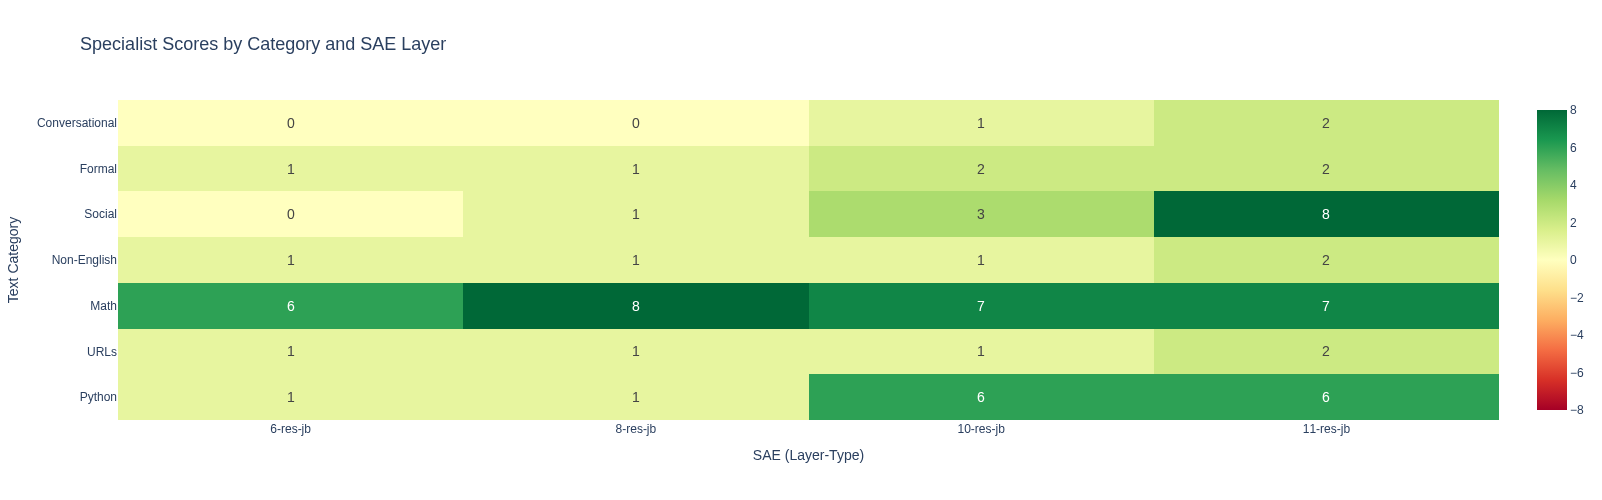


2️⃣ Building Strongest Activation Comparison...


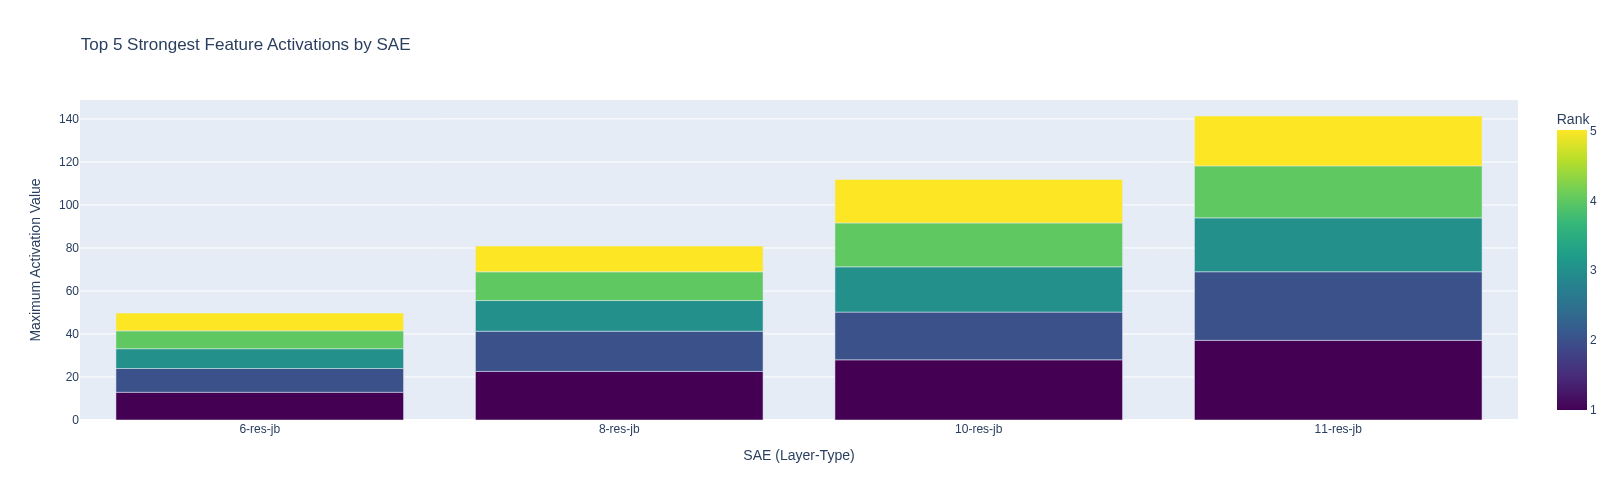


3️⃣ Building Feature Frequency Comparison...


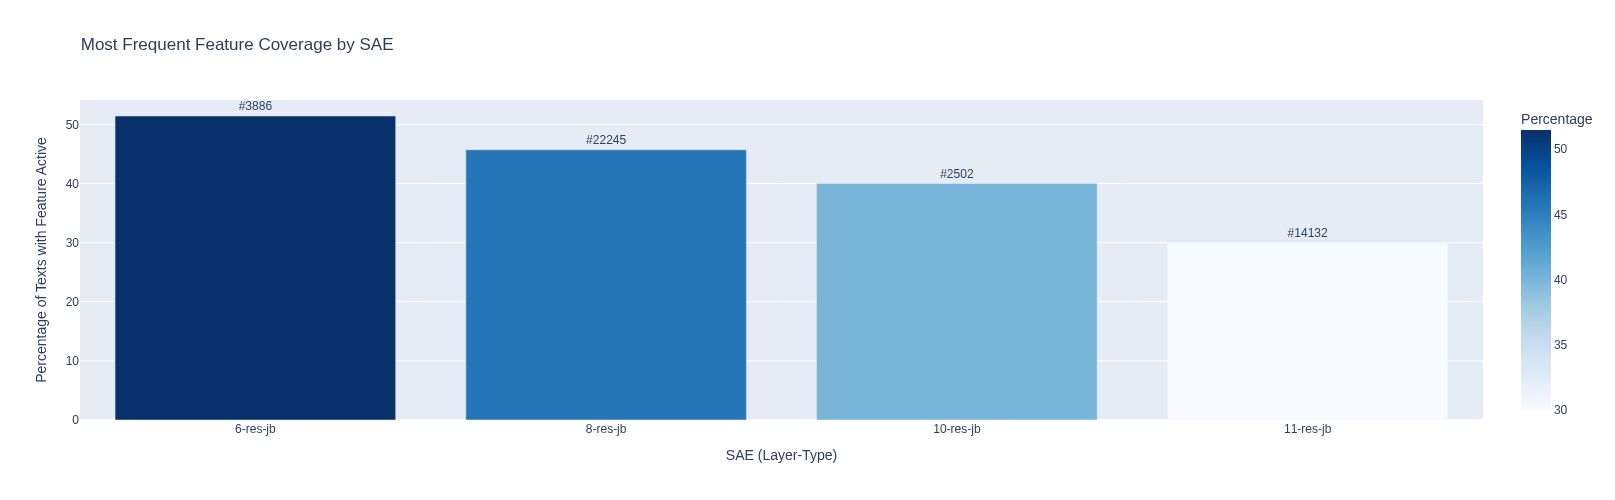


4️⃣ Building Layer Progression Analysis...


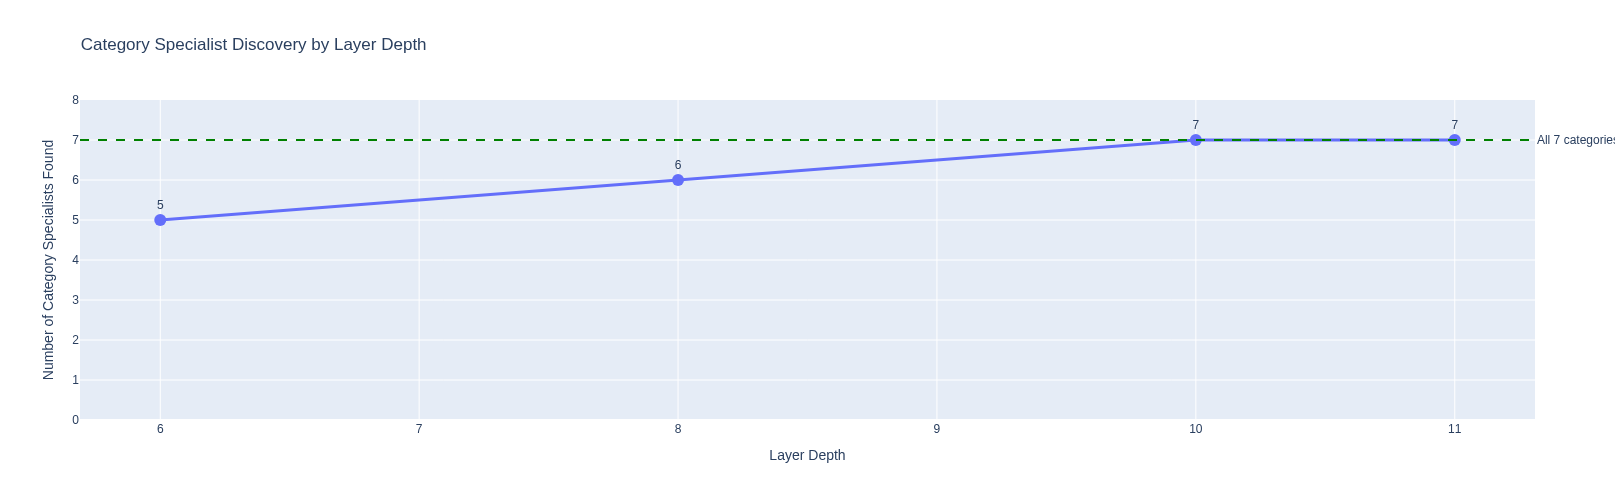


📈 HEATMAP INSIGHTS

✅ Categories with specialists in ALL SAEs (5):
   • Python
   • URLs
   • Math
   • Non-English
   • Formal

⚠️ Categories with specialists in SOME SAEs (2):
   • Social: 3/4 SAEs
   • Conversational: 2/4 SAEs

❌ Categories with NO specialists in any SAE (0):

🏆 Best Specialist Category per SAE:
   • 6-res-jb: Math (score: 6)
   • 8-res-jb: Math (score: 8)
   • 10-res-jb: Math (score: 7)
   • 11-res-jb: Social (score: 8)



In [11]:
# ============================================================================
# CELL 12: Phase 3 Comparison Heatmaps
# ============================================================================
print("\n📊 Phase 3 Comparison Heatmaps")
print("=" * 70)

# -----------------------------------------------------------------------------
# Heatmap 1: Specialist Scores by Category × SAE
# -----------------------------------------------------------------------------
print("\n1️⃣ Building Specialist Score Heatmap...")

# Build data for heatmap
sae_names = list(results['specialists'].keys())
category_names = list(categories.keys())

# Create matrix of specialist scores
specialist_matrix = []
for cat_name in category_names:
    row = []
    for sae_name in sae_names:
        cat_data = results['specialists'][sae_name].get(cat_name)
        score = cat_data['score'] if cat_data else 0
        row.append(score)
    specialist_matrix.append(row)

# Create heatmap
fig1 = go.Figure(data=go.Heatmap(
    z=specialist_matrix,
    x=sae_names,
    y=category_names,
    colorscale='RdYlGn',  # Red (negative) -> Yellow (zero) -> Green (positive)
    zmid=0,  # Center color scale at 0
    text=[[f"{val}" for val in row] for row in specialist_matrix],
    texttemplate="%{text}",
    textfont={"size": 14},
    hovertemplate="SAE: %{x}<br>Category: %{y}<br>Specialist Score: %{z}<extra></extra>"
))

fig1.update_layout(
    title={
        'text': 'Specialist Scores by Category and SAE Layer',
        'font': {'size': 18}
    },
    xaxis_title='SAE (Layer-Type)',
    yaxis_title='Text Category',
    height=500,
    width=800
)

fig1.show()

# -----------------------------------------------------------------------------
# Heatmap 2: Strongest Feature Max Activation by SAE
# -----------------------------------------------------------------------------
print("\n2️⃣ Building Strongest Activation Comparison...")

# For each SAE, get top 5 strongest features and their max activations
strongest_data = []
for sae_name in sae_names:
    sae_obj = loaded_saes[sae_name]['sae']
    hook_point = loaded_saes[sae_name]['config']['hook_point']
    features_tensor = extract_features(texts, sae_obj, hook_point)
    
    max_activations = features_tensor.max(dim=0)
    top_5 = max_activations.values.topk(5)
    
    for rank, (max_val, feat_idx) in enumerate(zip(top_5.values, top_5.indices), 1):
        strongest_data.append({
            'SAE': sae_name,
            'Rank': rank,
            'Feature': f"#{feat_idx.item()}",
            'Max Activation': max_val.item()
        })

df_strongest = pd.DataFrame(strongest_data)

# Create grouped bar chart
fig2 = px.bar(
    df_strongest, 
    x='SAE', 
    y='Max Activation', 
    color='Rank',
    barmode='group',
    title='Top 5 Strongest Feature Activations by SAE',
    hover_data=['Feature'],
    color_continuous_scale='Viridis'
)

fig2.update_layout(
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title='Maximum Activation Value'
)

fig2.show()

# -----------------------------------------------------------------------------
# Heatmap 3: Feature Frequency Comparison (Most Frequent Feature per SAE)
# -----------------------------------------------------------------------------
print("\n3️⃣ Building Feature Frequency Comparison...")

frequency_data = []
for sae_name in sae_names:
    freq_result = results['most_frequent'][sae_name]
    frequency_data.append({
        'SAE': sae_name,
        'Feature': f"#{freq_result['feature_idx']}",
        'Texts Active': freq_result['value'],
        'Percentage': (freq_result['value'] / 70) * 100
    })

df_frequency = pd.DataFrame(frequency_data)

fig3 = px.bar(
    df_frequency,
    x='SAE',
    y='Percentage',
    title='Most Frequent Feature Coverage by SAE',
    text='Feature',
    color='Percentage',
    color_continuous_scale='Blues'
)

fig3.update_traces(textposition='outside')
fig3.update_layout(
    height=500,
    width=800,
    xaxis_title='SAE (Layer-Type)',
    yaxis_title='Percentage of Texts with Feature Active'
)

fig3.show()

# -----------------------------------------------------------------------------
# Heatmap 4: Category Specialist Count Progression Across Layers
# -----------------------------------------------------------------------------
print("\n4️⃣ Building Layer Progression Analysis...")

# Count specialists per SAE
specialist_counts = []
for sae_name in sae_names:
    count = sum(1 for cat_data in results['specialists'][sae_name].values() 
                if cat_data and cat_data['score'] > 0)
    # Extract layer number from SAE name (e.g., "6-res-jb" -> 6)
    layer = int(sae_name.split('-')[0])
    specialist_counts.append({
        'SAE': sae_name,
        'Layer': layer,
        'Specialist Count': count,
        'Percentage': (count / 7) * 100
    })

df_progression = pd.DataFrame(specialist_counts)

fig4 = px.line(
    df_progression,
    x='Layer',
    y='Specialist Count',
    markers=True,
    title='Category Specialist Discovery by Layer Depth',
    text='Specialist Count'
)

fig4.update_traces(
    textposition='top center',
    line=dict(width=3),
    marker=dict(size=12)
)

fig4.add_hline(y=7, line_dash="dash", line_color="green", 
               annotation_text="All 7 categories", annotation_position="right")

fig4.update_layout(
    height=500,
    width=800,
    xaxis_title='Layer Depth',
    yaxis_title='Number of Category Specialists Found',
    yaxis=dict(range=[0, 8])
)

fig4.show()

# -----------------------------------------------------------------------------
# Summary Statistics
# -----------------------------------------------------------------------------
print("\n" + "=" * 70)
print("📈 HEATMAP INSIGHTS")
print("=" * 70)

# Find which categories have specialists across ALL SAEs vs only some
always_specialist = []
sometimes_specialist = []
never_specialist = []

for cat_name in category_names:
    scores = [results['specialists'][sae_name][cat_name]['score'] 
              for sae_name in sae_names 
              if results['specialists'][sae_name].get(cat_name)]
    
    positive_count = sum(1 for s in scores if s > 0)
    
    if positive_count == len(sae_names):
        always_specialist.append(cat_name)
    elif positive_count == 0:
        never_specialist.append(cat_name)
    else:
        sometimes_specialist.append((cat_name, positive_count))

print(f"\n✅ Categories with specialists in ALL SAEs ({len(always_specialist)}):")
for cat in always_specialist:
    print(f"   • {cat}")

print(f"\n⚠️ Categories with specialists in SOME SAEs ({len(sometimes_specialist)}):")
for cat, count in sometimes_specialist:
    print(f"   • {cat}: {count}/{len(sae_names)} SAEs")

print(f"\n❌ Categories with NO specialists in any SAE ({len(never_specialist)}):")
for cat in never_specialist:
    print(f"   • {cat}")

# Best category per SAE (highest specialist score)
print(f"\n🏆 Best Specialist Category per SAE:")
for sae_name in sae_names:
    best_cat = max(results['specialists'][sae_name].items(), 
                   key=lambda x: x[1]['score'] if x[1] else -999)
    print(f"   • {sae_name}: {best_cat[0]} (score: {best_cat[1]['score']})")

print("\n" + "=" * 70)